# Microsoft Studio: Box Office Analysis
**Author:** James Pheby


## Overview

Descriptive analysis of the last 15 years of box office profits to produce recommendations for Microsoft Studio on which type of movie it should produce, when it should produce it and what features the movie should include. 
-  Wait until the major markets have fully reopened after the pandemic lockdowns before releasing the movie 
-  The film should be in the thriller/horror genre
-  The film studio should try and recruit Rose Byrne and Jordan Peele to direct and write

## Business Problem

-  Maximise the likelihood of producing a profitable movie for stakeholders

-  Make efficient use of a realistic budget for the studio's debut movie

-  Recruit crew with a track record of producing profitable and acclaimed movies

-  Include features often associated with successful movies in the chosen genre

## Data Understanding
Data drawn from three sources:
-  Box office performance of more the 7,000 movies from The Numbers website
-  Genre, crew, and release date of each movie from Open Movie Database (OMDB). This also contains average user ratings from Rotten Tomatoes, Imdb and Metacritic 
-  Keywords attached to each movie from The Movie DB (TMDB)



In [1]:
from selenium import webdriver
from PIL import Image
import os
from os import path
import time
import random
import pandas as pd
import requests
import json
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import code.visualizations as viz
import code.data_preparation as dprep

In [3]:
api_keys = dprep.get_api_keys()
omdb_key = api_keys[0]
imdb_key = api_keys[1]
tmdb_key = api_keys[2]


In [4]:
# opens the dataframes constructed from scraped data
(financials_list, numbers_df, financials_15_df, omdb_attrs, attributes_df) = dprep.open_files()


**Save dataframes at the end of the session**

In [5]:
dprep.save_files(financials_list, numbers_df, financials_15_df, omdb_attrs, attributes_df)

**If not scraping skip until....**

In [6]:
# scrape financial details from the numbers website, 
# make numbers_df, clean the data and filter for only last 15 years

financials_list = dprep.the_numbers_scraping()

KeyboardInterrupt: 

In [ ]:
# make numbers_df, filter out corrupt/anomolous rows by rejecting movies
# with no worldwide takings and movies with budget <$1m 
# only include movies with presence in the US

numbers_df = dprep.construct_prepare_numbers_df(financials_list)

In [ ]:
# make financials_df, copy of number_df with cleaned data, filtered for only
# last 15 years and empty column added to hold imdb_code

financials_15_df = dprep.make_fin_15(numbers_df)


In [6]:
# use omdb api to get attributes for movies in numbers_df
# create a new df that is a copy of numbers_df but with the imdb_code, which 
# will be used as the primary key, filled in. Do this so we have a separate df
# after each time-consuming scrape/api session, so it easier to isolate different
# blocs of code to work with
# the function call also creates a global dictionary of the omdb attributes that
# will be used to create the attributes database

(omdb_attrs, financials_15_df) = dprep.make_omdb_dict(financials_15_df, omdb_key)

C:\Users\james\Documents\flatiron_data_science\phase1\Project_fin\dsc-phase-1-project\code\data_preparation.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financials_15_df['imdb_code'][financials_15_df.title == movie] = imdb_id


In [12]:
# manual imdb code insertion for problematic titles
financials_15_df = dprep.update_make_omdb_dict(financials_15_df, omdb_key)

In [17]:
# makes a dataframe of movie attributes using omdb api, imdb key is primary key
attributes_df = dprep.make_attributes_df()

KeyError: 'imdbRating'

**...here**

## Data Preparation

The worldwide box office takings for the last 15 years were cleaned, so they could be stored as integers.

Any films with corrupt data, often giving corrupt release date, was filtered out in the process. 

Any movie with a budget with less than $1m was filtered out, as it is either corrupted or anomalous, with the potential to skew the return on investment figures

Any movie with takings only outside the USA, or with no worldwide takings recorded were removed, as either corrupted or not relevant to the business problem

Any other null values were treated according to the analysis, and is explained in the code

We change any N/A empty ratings into NaN in order to make the mean_rating column numerical. We can leave those in as it is not a much used column, and when it is used, it is easy to deal with them in a way most appropriate to the anlaysis

Each movie released in the last 15 years was ranked using a combination of gross box office profit and return on investment, giving a way of comparing the performance of movies with different budgets

The best ranked movies were then analysed to find the most profitable genres

Within those genres, the movies were analysed to find which actors, directors and writers were most successful, and the runtime, release month and rating classifications most associated with hits



In [5]:
# make dataframe that only includes profitable films
# also eliminates all movies with no worldwide or domestic
# recorded takings (assume we are making an english speaking film)

financials_hits_df = dprep.make_hit_df(financials_15_df)

In [6]:
# do same but for flops

financials_flops_df = dprep.make_flop_df(financials_15_df)


In [7]:
# make three joined dataframes, one for each financial dataframe

(financial_attributes_join, financial_attributes_hits_join, financial_attributes_flops_join) = dprep.make_joined_dfs(financials_15_df, financials_hits_df, financials_flops_df, attributes_df)


**DATAFRAMES** <br><br>
**numbers_df** - all financial data from The Numbers website<br>
**financials_15_df** - all financial data for numbers movies in last 15 years <br>
**financials_hits_df** - same data but filtered out loss making movies, those only succesful outside english speaking world and those with no documented figures <br>
**financials_flops_df** - same but filtered out profit making movies <br>
<br>

**JOINED**

**financial_attributes_hits_join** - hits financial data joined with attributes <br>
**financial_attributes_flops_join** - flops financial data joined with attributes <br>
**financial_attributes_join** - all financial data joined with attributes

## Data Modeling

**Line plot to visualise the yearly trend in worldwide box office takings**

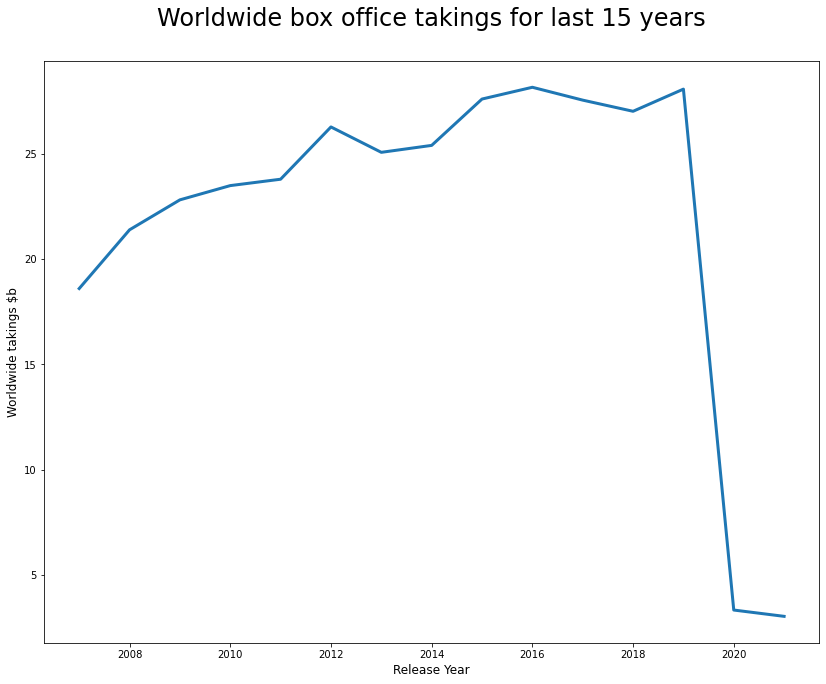

In [8]:
ww_df = financial_attributes_join.groupby('release_year').sum()
ww_df['worldwide_box_office_$'] = ww_df['worldwide_box_office_$']/1000000000
ww_df = ww_df[:15]
viz.lineplotter(ww_df, "release_year", "worldwide_box_office_$", 'Worldwide box office takings for last 15 years', 'Release Year', 'Worldwide takings $b', 'images/worldwide_bo.png');


<font color='red'>**Despite a steady rise since 2007, takings were almost totally wiped out by the lockdowns, and have yet to tick up again. With many large markets still in and out of lockdown, there is little chance of turning a profit until there is more stability**</font> 

**Make a bar chart showing the best profit ranked films by genre**

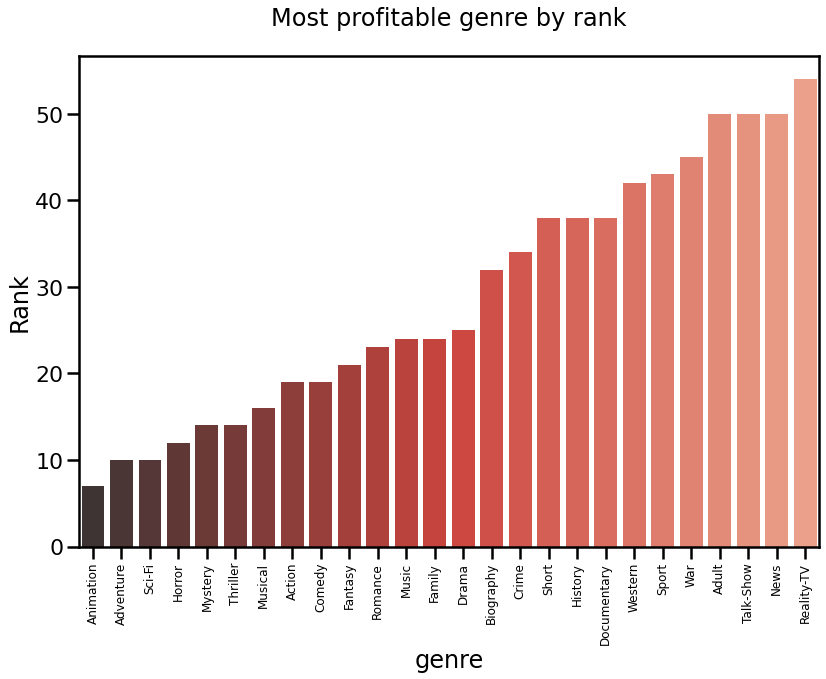

In [9]:
genre_df = dprep.ranked_df_maker(['Genre_List'], financial_attributes_join) 
genre_df = genre_df.reset_index()
# filter out any movies where genre list is blank
genre_df = genre_df[genre_df.Genre_List != 'N/A']
viz.rank_seaborn_bar(genre_df, 'Genre_List', 'genre', "Most profitable genre by rank", 'images/genre_rank.png');


<font color='red'>**Animation, Adventure, Sci-Fi, Horror, Mystery and Thriller are the 6 best performing genres at the box office. This combines gross takings and return on investment, so we need to dig into which fits our needs the best** </font> 

**Make grouped bar chart showing number of hits and flops for major genres**

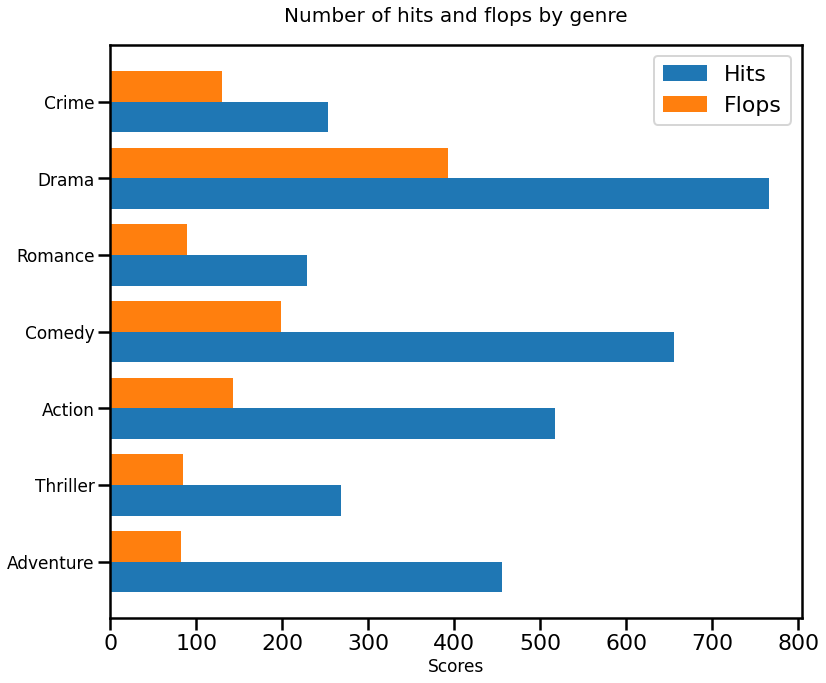

In [10]:
filtered_concat_gen_df = dprep.make_profit_loss_df(financial_attributes_join, financial_attributes_flops_join, financial_attributes_hits_join)
viz.grouped_bar_genre(filtered_concat_gen_df)

<font color='red'>**Being a new studio, a top priority is not making a flop first out. Of the popular genres, Crime and Drama present the most risk of a flop, with adventure the least. Action, Thrillers and Comedies all present good odds of turning a profit**  </font> 

**Make bar chart showing mean budget per genre**

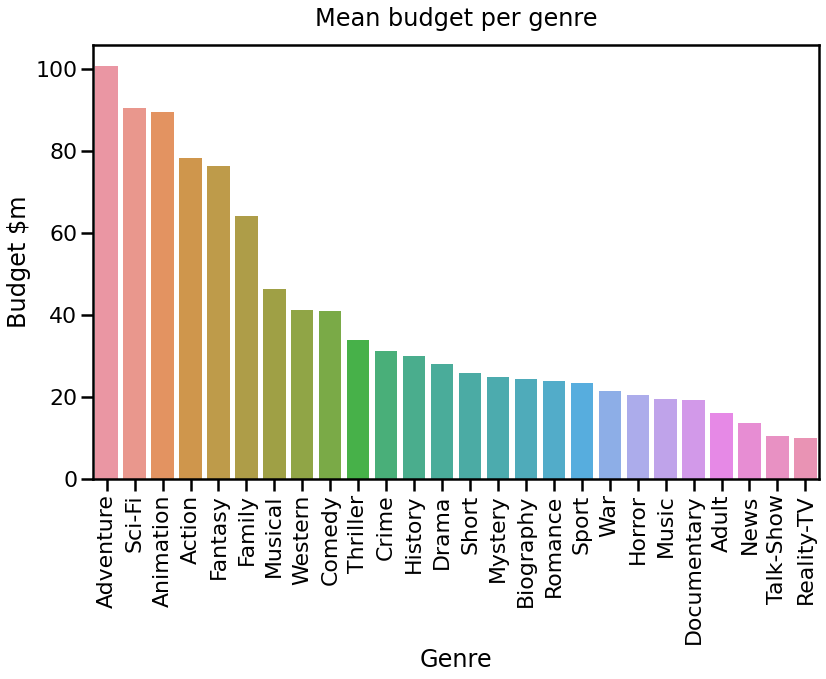

In [11]:
viz.budget_profit_bar(genre_df)

<font color='red'>**We also need to take into account the budget. The high budgets of Adventure, Sci-Fi, Action and Fantasy movies present risks of losses that could end the studio after one movie, something best to be avoided!** </font> 

**Make grouped bar chart showing gross profits and losses for major genres**

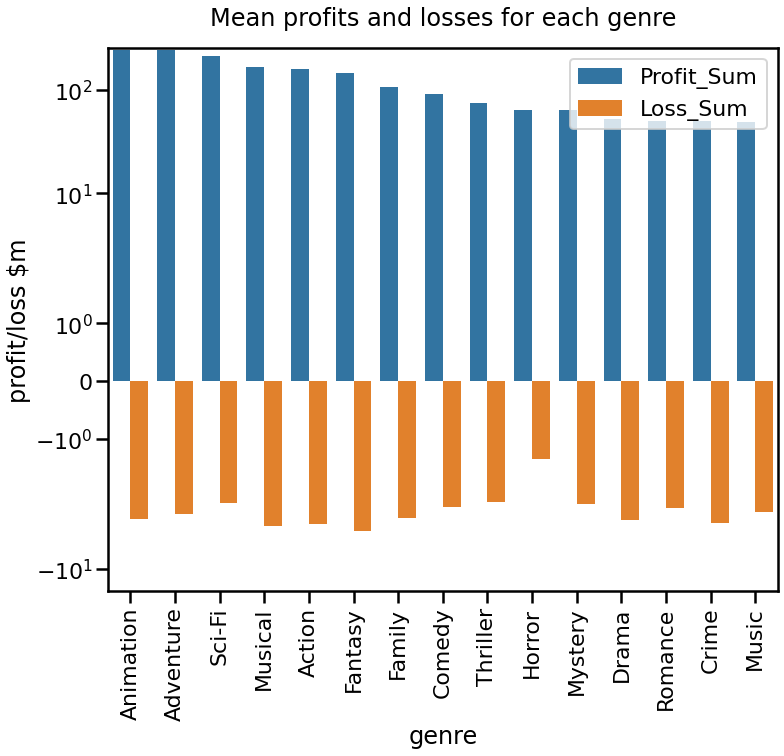

In [12]:
viz.p_l_gross_group_bar(financial_attributes_join)

<font color='red'>**Note that the y-scale is log, so the chances of making money are better than at first glance.**

**But this graph is helpful in showing the mean average loss that a loss-making film in each genre makes. Fantasy, Action and Musicals all end to lose big, if they lose, while Sci-Fi, Thrillers, Horror and Mystery tend to have more sustainable losses, particularly Horror.** </font> 

**Make box plot to show the variance in gross profit and loss by genre**

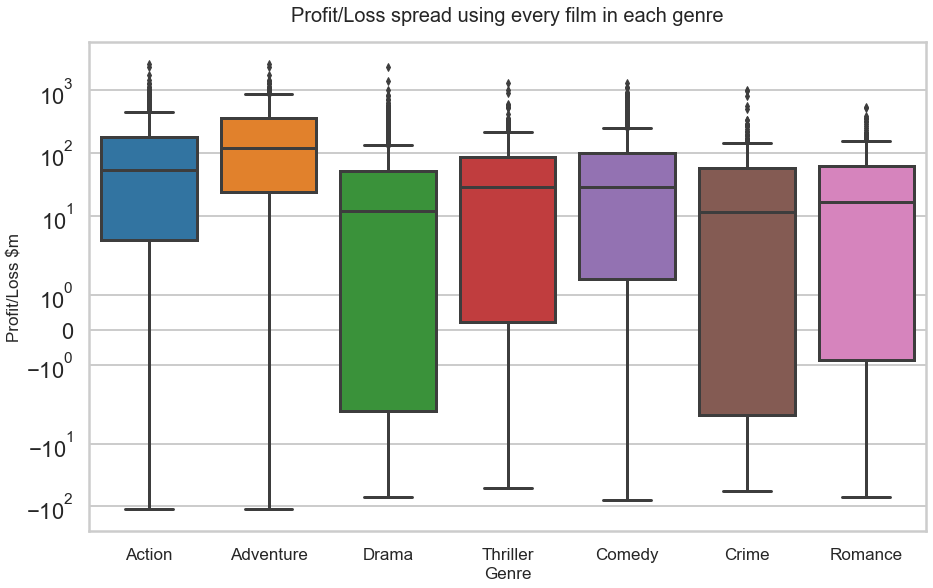

In [13]:
viz.profit_box_plot(financial_attributes_join)

<font color='red'>**This can also be seen in the box plot above, which demonstrates the spread of the fortunes that have been won and lost by films in each genre, with the box representing the most likely result.**
    
**Action and Adventure both have long tails, showing how much can be lost, even though they tend to turn more gross profit. These are both consequences of the large budgets involved**
    
**Thrillers lost the least, on average, and held their own in the upper reaches, with only costly Action and Adventures showing a clear advantage***
    
**Taking into account the likelihood in turning a profit, limited potential losses, realistic budget for a new studio and the reasonable potential at making a solid hit, a Thriller represents a good all round choice**
</font> 

**Now we've made a decision that thriller is the best all round choice we focus on the hits_df as we want to find what makes a profitable movie in the genre**

**Firstly we make a lineplot showing the returns of films by budget, split into thrillers and non thrillers**

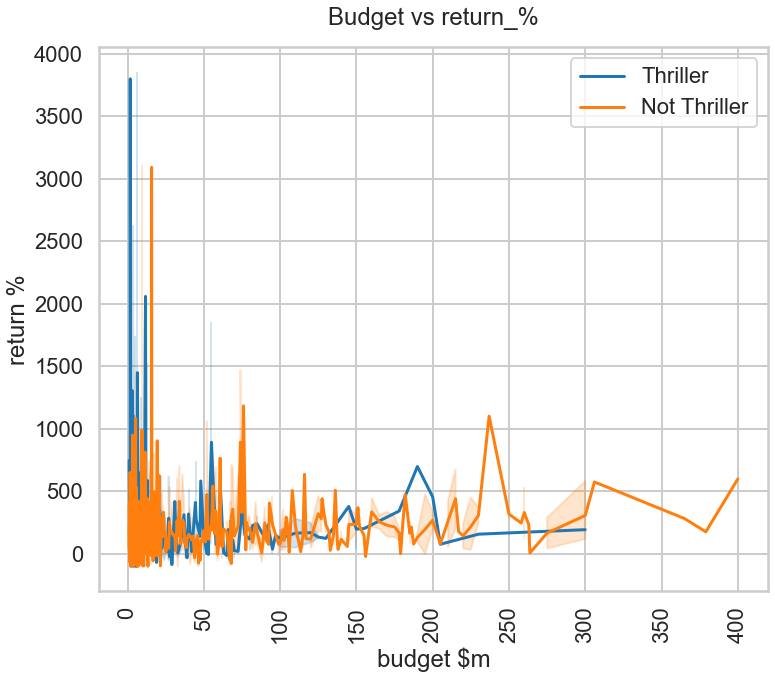

In [14]:
viz.budget_line(financial_attributes_join)

<font color='red'>**The blue line shows the return on budget for Thrillers, while the blue every other movie. We can see the blue spikes generally further left showing that they are efficient at turning a profit at more modest budgets
There is a spike very close to zero, which represents unlikely shoestring hits, and not something to affect our choice.**
    
**The spikes rise between around 20 and 50 million, beofre falling away, representing the type of budget we should be looking at**
</font> 

**Make a barchart showing the best profit ranked subgenres withing he thriller genre** 

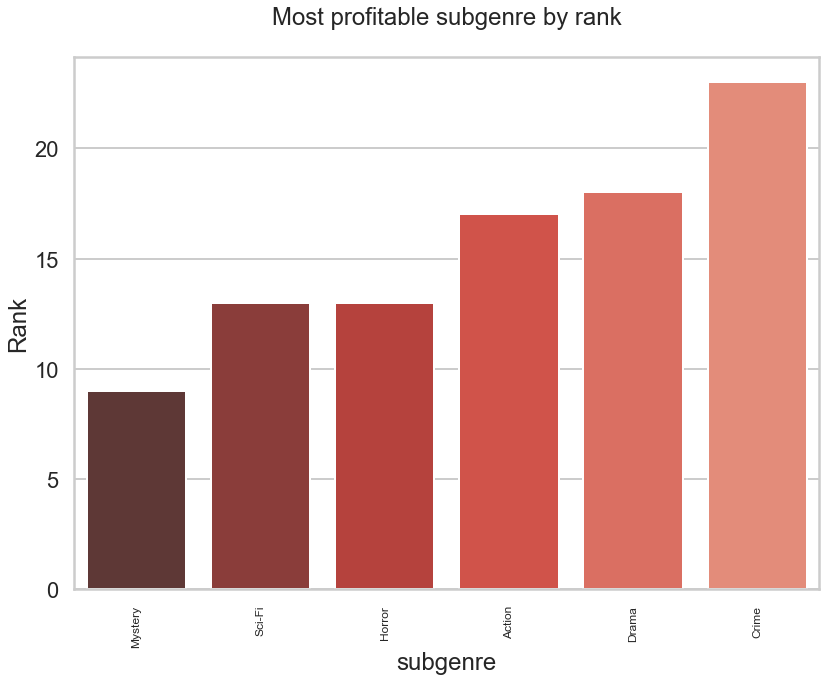

In [15]:
# creates a dataframe only showing hit thrillers
thriller_df = dprep.ranked_df_maker(['Genre_List'], financial_attributes_hits_join, ['Thriller'])  
thriller_df_sub = thriller_df.reset_index()
thriller_df_sub = thriller_df_sub[(thriller_df_sub['Genre_List'] != 'Thriller') & (thriller_df_sub['Counts'] > 20)]
viz.rank_seaborn_bar(thriller_df_sub, 'Genre_List', 'subgenre', "Most profitable subgenre by rank", 'images/subgenre_rank.png');

<font color='red'>**Being quite a wide genre, we need to concenrate on what type of Thriller we should make. This ranked bar graph shows that Mystery, Horror and Sci-Fi all perform very well. Given Sci-Fi's high budgets, a Thriller/Mystery/Horror movie is the best option**</font> 

**We make a decision for a Thriller/Mystery/Horror due to all count and rank combination**

**Now find attributes most commonly associated with profitable movies in that genre**


**Make scatterplot showing return on budget for thrillers, showing values for each subgenre**

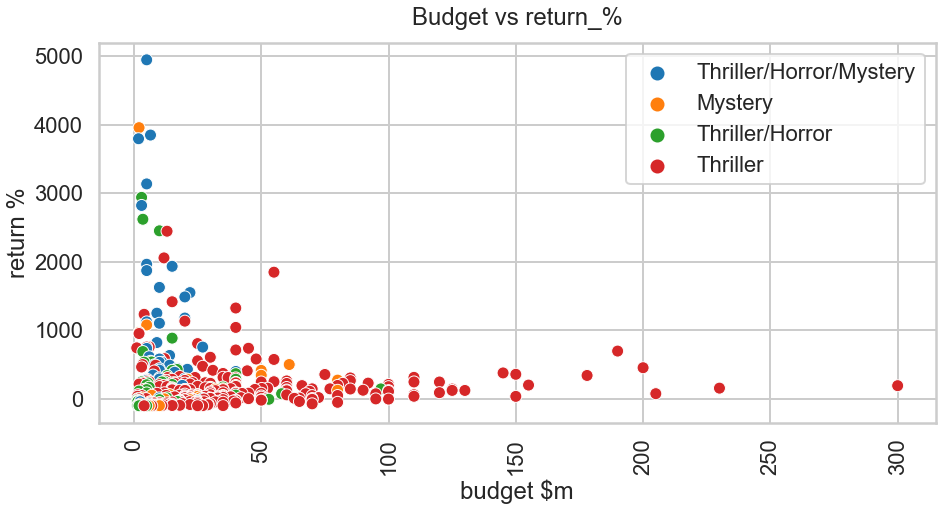

In [16]:
# make a clean thriller dataframe, not joined by genre 
add_thriller_list=[]
for index, row in financial_attributes_join.iterrows():
    if 'Thriller' in row['Genre_List']:
        add_thriller_list.append(row)
thriller_all = pd.DataFrame(add_thriller_list)
thriller_all_s = dprep.budget_prep(thriller_all)
thriller_all_s
viz.budget_sub_scatter(thriller_all_s)

<font color='red'>**Here we see the return per budget, with the blue dots representing the chosen genre. These spikes are clustered towards the lower end of our budget range, so we should be looking at the 20-30 million range**</font> 

**Make bar graphs of best profit ranked actors, directors and writers popular in the genre**


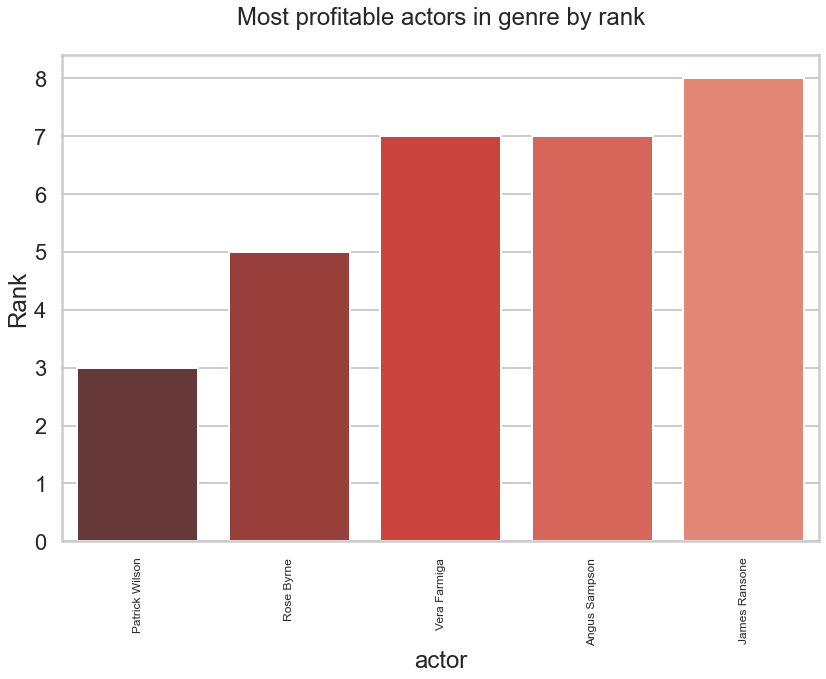

In [18]:
actor_df = dprep.ranked_df_maker(['Actor_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror']) 
actor_df=actor_df.reset_index()
actor_df = actor_df[actor_df.Actor_List != 'N/A']
viz.rank_seaborn_bar(actor_df, 'Actor_List', 'actor', "Most profitable actors in genre by rank", 'images/actor_rank.png');

<font color='red'>**Patrick Wilson is ranked most profitable actor in the genre, but Rose Byrne and Vera Farmiga also score well**</font> 

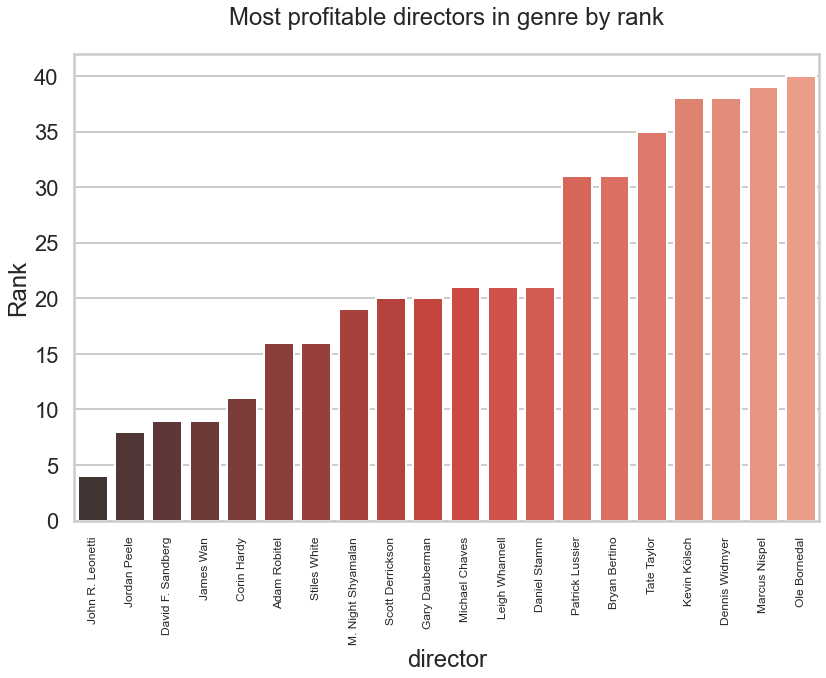

In [19]:
director_df = dprep.ranked_df_maker(['Director_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])[:20] 
director_df = director_df.reset_index()
director_df = director_df[director_df.Director_List != 'N/A']
viz.rank_seaborn_bar(director_df, 'Director_List', 'director', "Most profitable directors in genre by rank", 'images/director_rank.png');

<font color='red'>**As for director, John R. Leonetti, Jordan Peele and James Wan all look good choices**</font> 

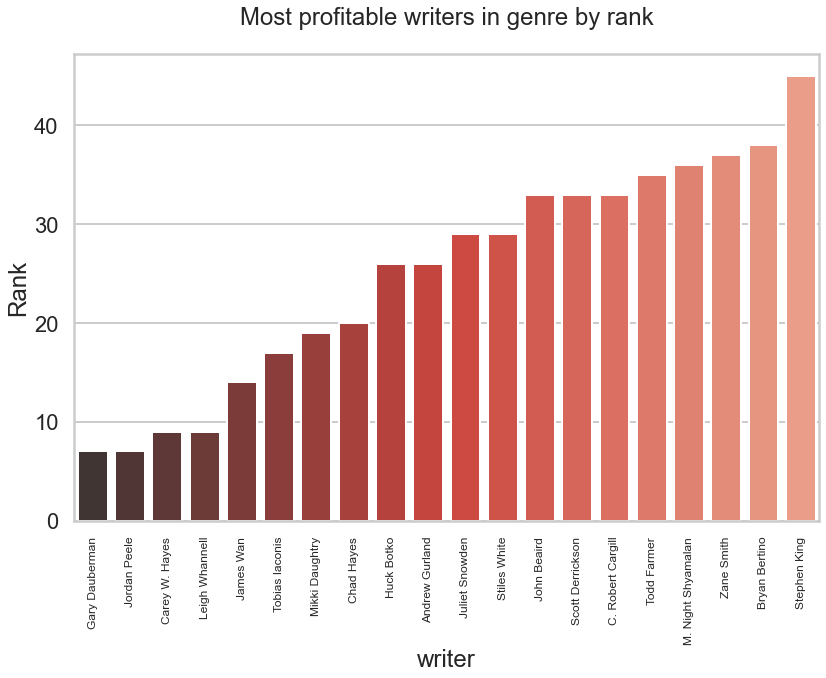

In [20]:
writer_df = dprep.ranked_df_maker(['Writer_List'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])[:20]  
writer_df = writer_df.reset_index()
writer_df = writer_df[writer_df.Writer_List != 'N/A']
viz.rank_seaborn_bar(writer_df, 'Writer_List', 'writer', "Most profitable writers in genre by rank", 'images/writer_rank.png');

<font color='red'>**Jordan Peele and James Wan both score highly once again, and either presents a good choice to write and direct the film**</font> 

**Make subplots showing the relative perfomances of the best performing crew members in the genre**

In [21]:
top_full_crew_df = dprep.make_crew_df(financial_attributes_join)


In [22]:
top_actors = ['Rose Byrne', 'Vera Farmiga', 'Patrick Wilson', 'Angus Sampson', 'James Ransone']
top_directors = ['John R. Leonetti', 'Jordan Peele', 'James Wan', 'David F. Sandberg', 'Corin Hardy']
top_writers = ['Gary Dauberman', 'Leigh Whannell', 'Carey W. Hayes', 'Jordan Peele', 'James Wan']

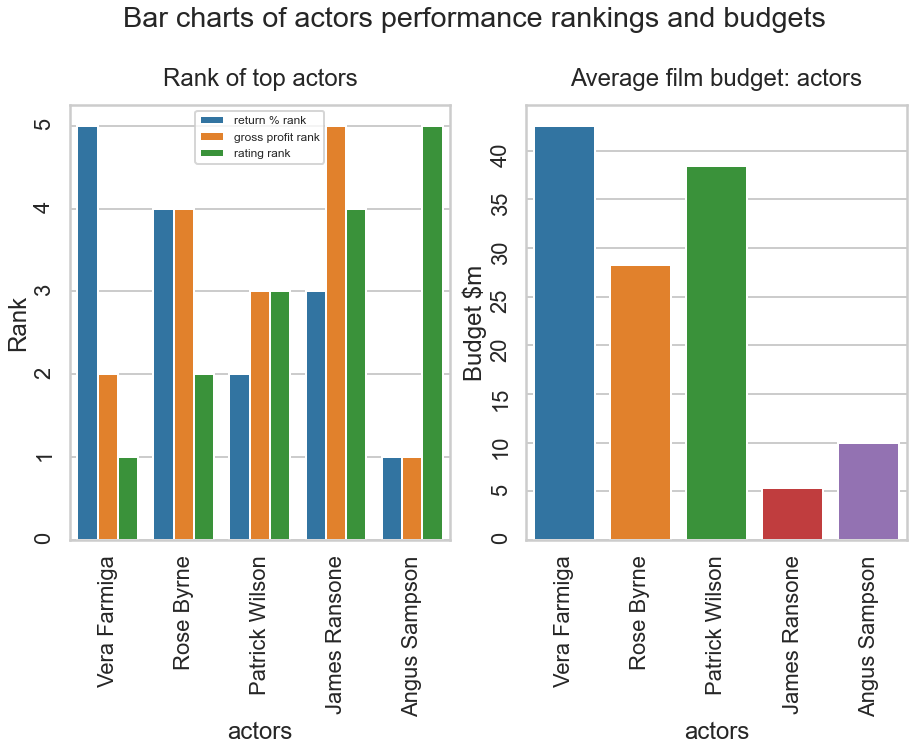

In [23]:
act_group = viz.graph_generator(top_full_crew_df, 'Actor_List', top_actors, 'actors')

<font color='red'>**We look at the user ratings for the first time, and notice little link among the top actors between critical praise and box office returns, with the most profitable avtor ranking last in ratings, and the best rated actress the least profitable, in terms or ROI.**

**Rose Byrne gets good all round scores, along with Patrick Wilson, but operates more within the decided budget range. Although we are looking primarily at the box office, we still need to consider the critical reception as the studio builds a reputation.** </font> 

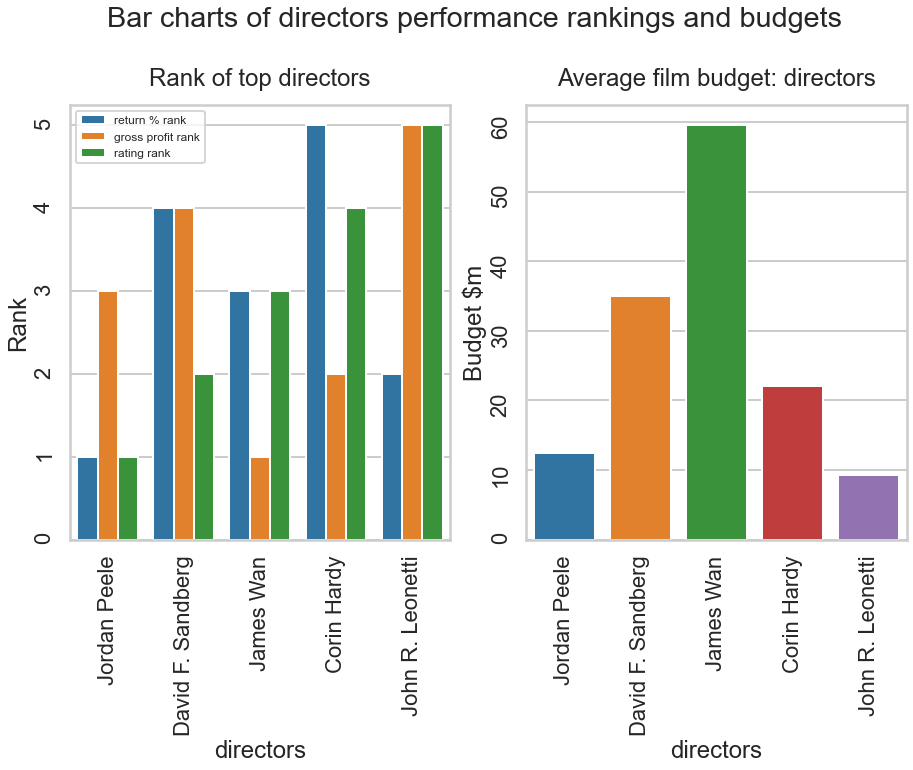

In [24]:
dir_group = viz.graph_generator(top_full_crew_df, 'Director_List', top_directors, 'directors')

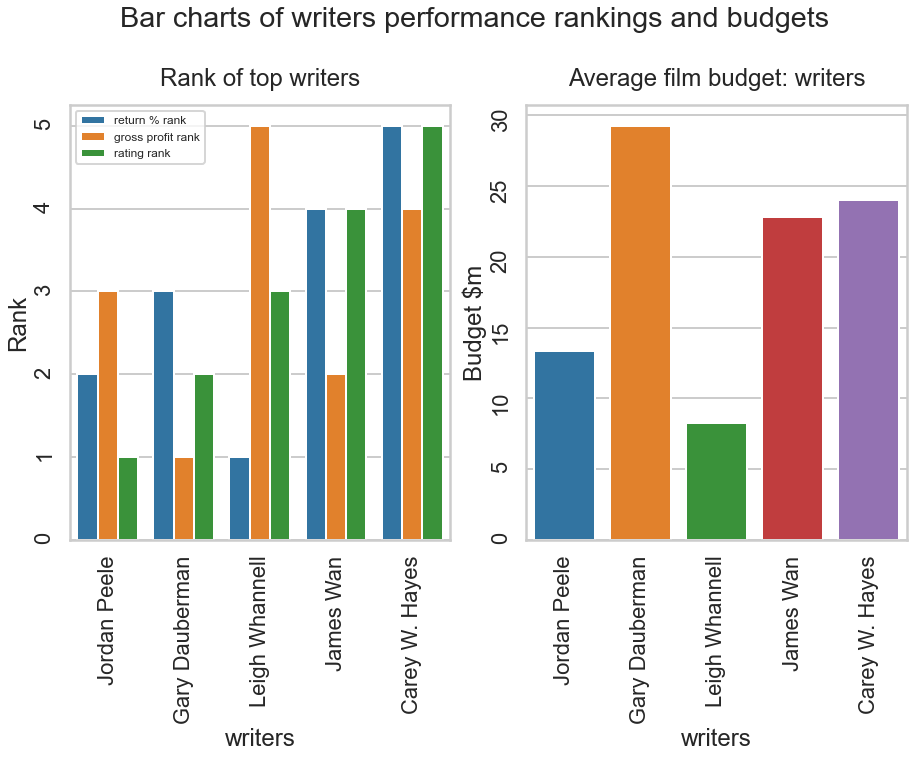

In [25]:
writer_group = viz.graph_generator(top_full_crew_df, 'Writer_List', top_writers, 'writers')

<font color='red'>**Jordan Peele is the standout choice for writer and director in terms of both profitability and critical success. He also is used to working at the lower end of our budget range, so makes the ideal choice**</font> 

**Make plot to see link between user ratings and profitability**

**Make ranked bar charts showing most profitable runtime, rated, ratings and release month**


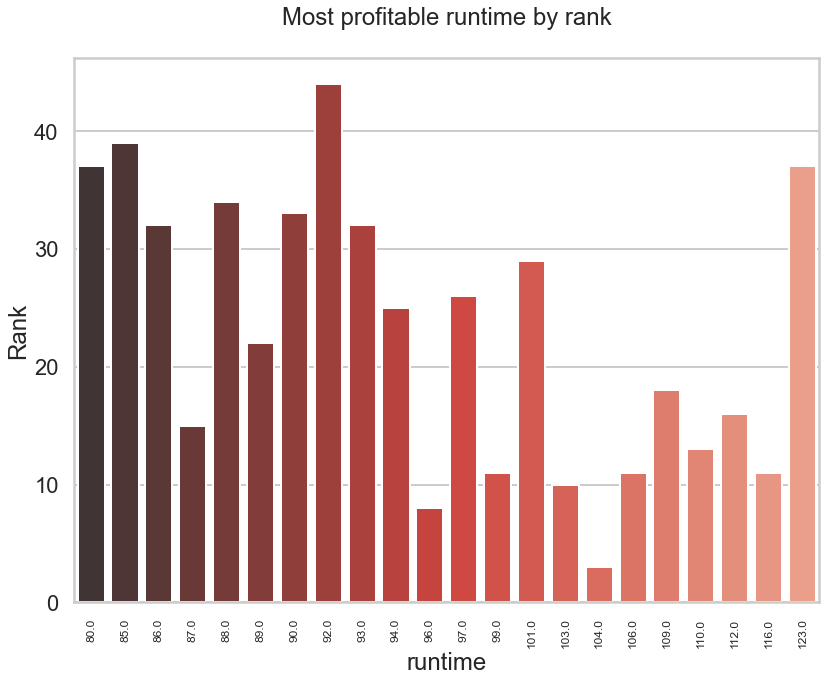

In [27]:
runtime_df = dprep.ranked_df_maker(['Run_Time'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
runtime_df = runtime_df.reset_index()
runtime_df = runtime_df.sort_values(by='Run_Time')
viz.rank_seaborn_bar(runtime_df, 'Run_Time', 'runtime', "Most profitable runtime by rank", 'images/runtime_rank.png');

<font color='red'>**The movie should be between 96 and 110 minutes long, as that's where the best perfomring movies in the genre are concentrated**</font> 

In [ ]:
<font color='red'>bar</font> 

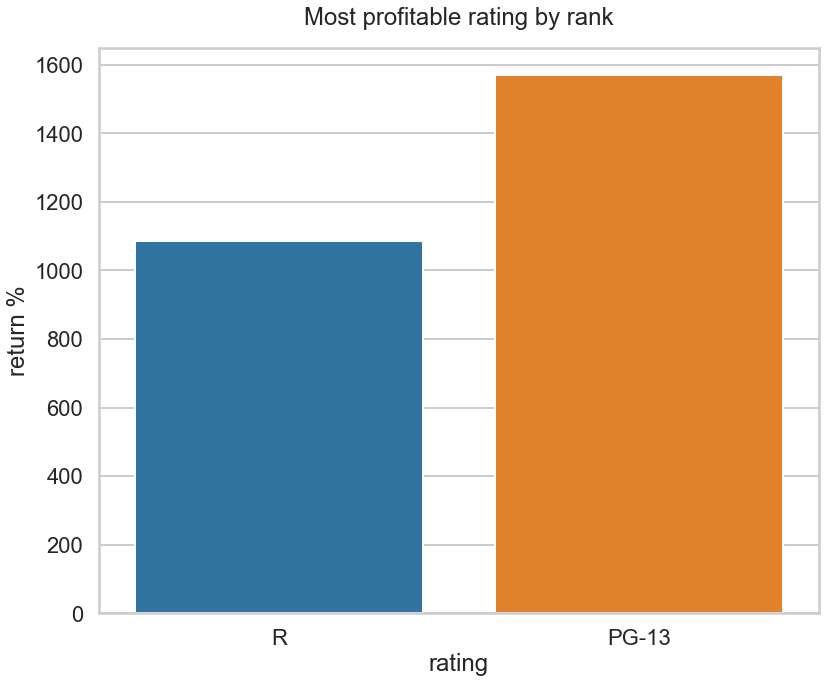

In [28]:
ranked_df = dprep.ranked_df_maker(['Rated'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
ranked_df = ranked_df.reset_index()
viz.rated(ranked_df)

<font color='red'>**And it should be targetted at a PG-13 market**</font> 

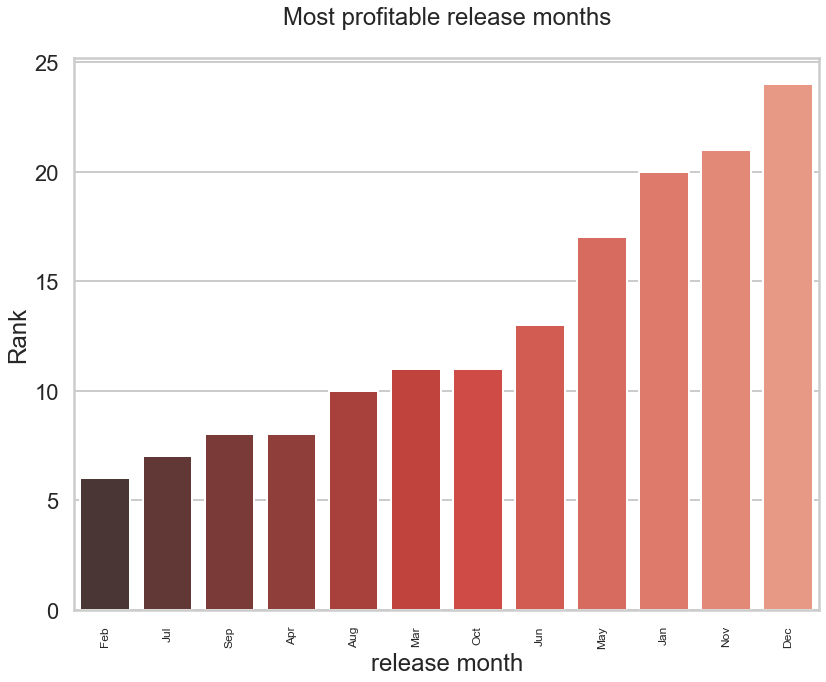

In [29]:
release_month_df = dprep.ranked_df_maker(['release_month'], financial_attributes_hits_join, ['Thriller', 'Mystery', 'Horror'])
release_month_df=release_month_df.reset_index()
viz.rank_seaborn_bar(release_month_df, 'release_month', 'release month', "Most profitable release months", 'images/month_rank.png');

<font color='red'>**Halloween isn't particularly good for films in our genre, instead February and July score the best. Along with the recovery from the pandemic, the best release date would with be July 2022 or February 2023, lockdowns depending**</font> 

**Make plot showing yearly trend of total takings by every genre, and by thriller/horror**

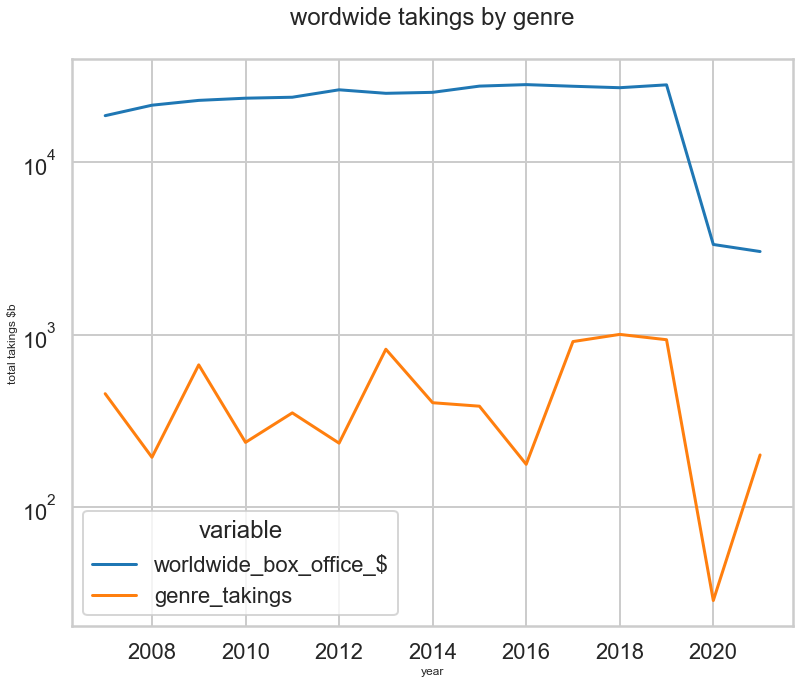

In [30]:
viz.overall_time_trend(financial_attributes_join)

<font color='red'>**We're again using a log scale, to make it easier to see the trend of our genre vs the general trend**

**There are early signs that the genre is outperforming the pack as life opens up again, having seen a recovery this year**</font> 

**Make ranked bar graph of best performing movies in the genre over last 15 years**

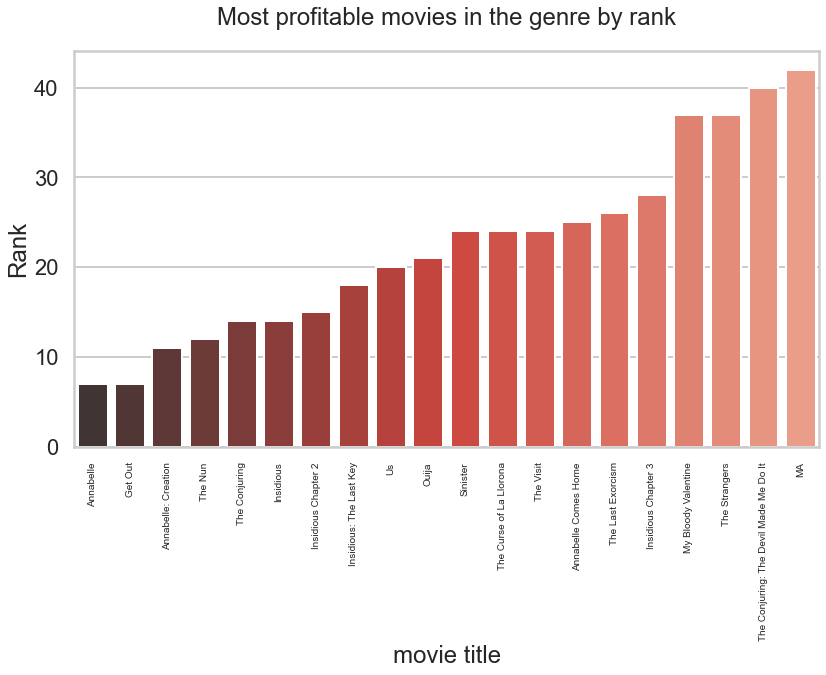

In [31]:
viz.best_genre_films(financial_attributes_join)

<font color='red'>**Here we see the best perfoming films in the genre too get an idea of the type of film that has performed well in recent years**
**Jordan Peele scores highly with both 'Get Out' and 'Us'**</font> 

<font color='red'>**BONUS TIP! - Here are the keywords associated with the best ranking films in the genre. A credit stinger could be a good idea!**</font> 

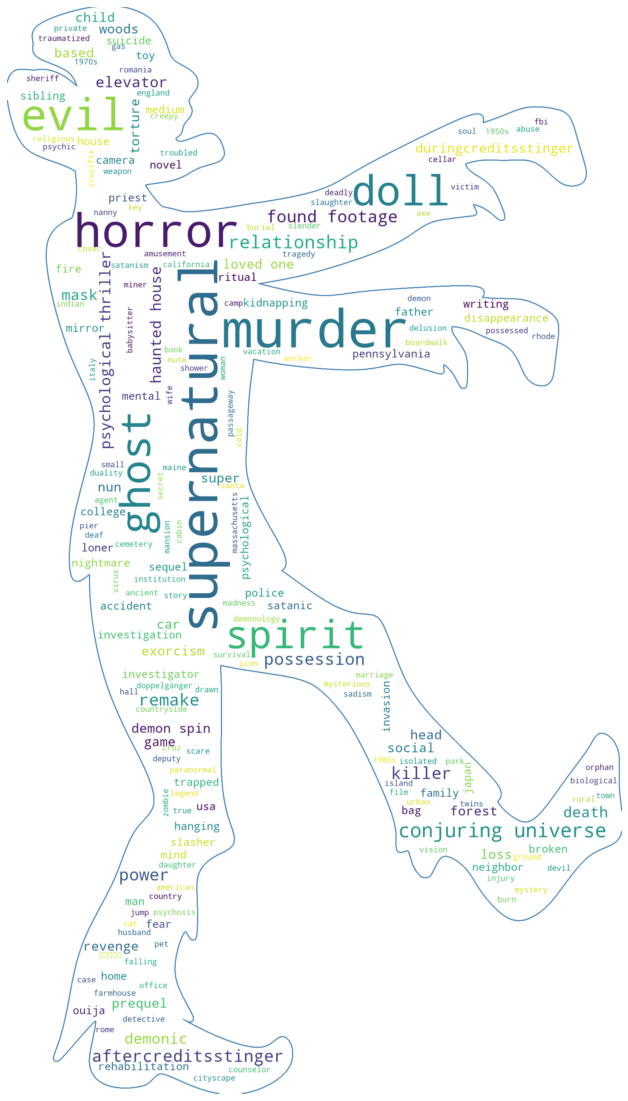

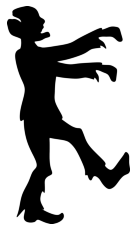

In [9]:
text = dprep.omdb_genre_keywords(financial_attributes_hits_join, tmdb_key)
viz.wordcloud(text)